In [2]:
import os 
import random  

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# Set reprodicibility

seed = 41

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

## Dataset loading

In [5]:
from utils.dataset_loader import load_datasets

(texts_train, labels_train), (texts_val, labels_val), (texts_test, labels_test) = load_datasets(folder_path='dataset', 
                                                                                                divide_by_sentence=True,
                                                                                                group_numbers=True)


### Analysis of the training set

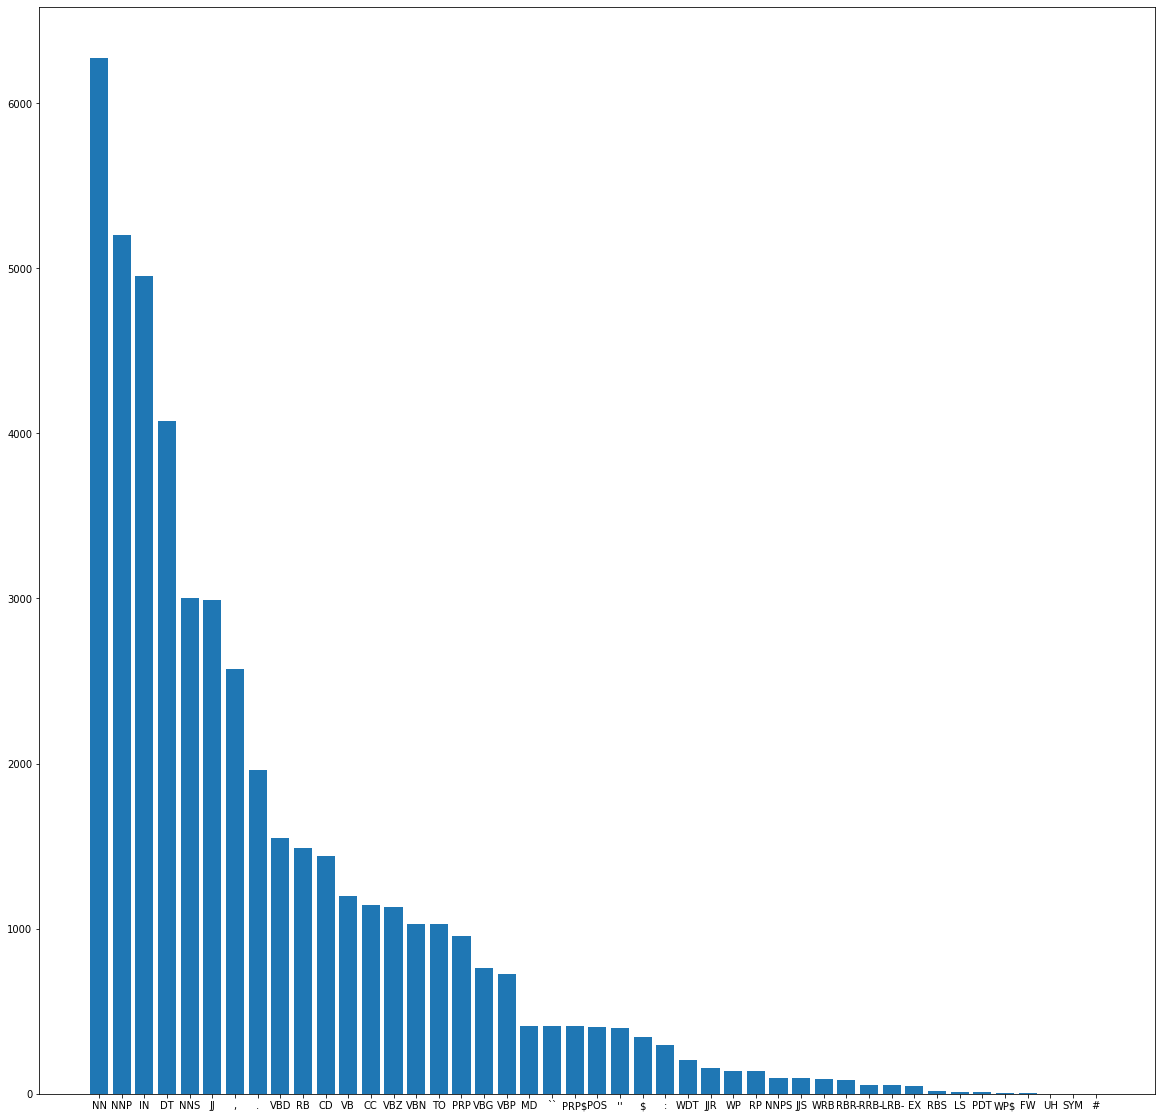

In [6]:
# Distribution of the POS tags

from collections import Counter

labels_train_lists = []
for s in labels_train:
    labels_train_lists.extend(s.split())

POS_tags = np.array(list(Counter(labels_train_lists).keys())) # equals to list(set(words))
POS_tags_counts = list(Counter(labels_train_lists).values()) # counts the elements' frequency

POS_tags = POS_tags[np.argsort(POS_tags_counts)][::-1]
POS_tags_counts = sorted(POS_tags_counts)[::-1]

plt.figure(figsize=(20,20))
plt.bar(POS_tags, POS_tags_counts);

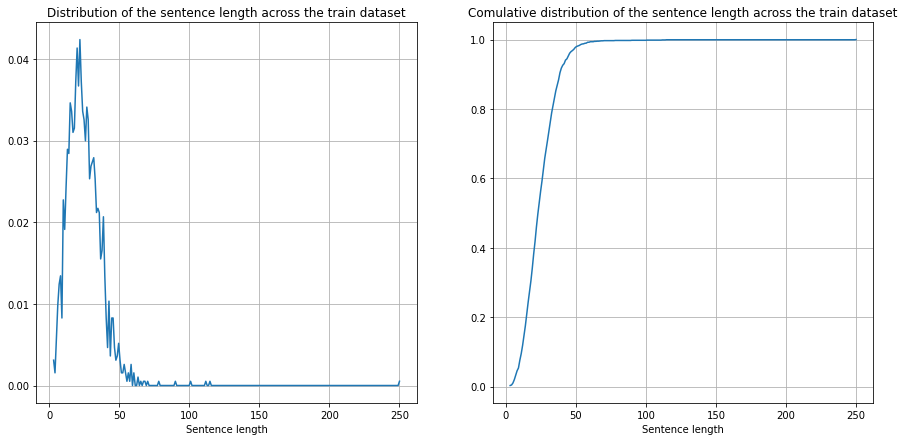

In [7]:
# Analysis of the sentences length (i.e. number of tokens) 

# Length of each training sentence
train_sentences_lenghts = [len(sentence.split(' ')) for sentence in texts_train]

# Histogram of the sentences length distribution
hist, bin_edges = np.histogram(train_sentences_lenghts, bins=np.max(train_sentences_lenghts) + 1, density=True) 
# Cumulative distribution of the sentences length
C = np.cumsum(hist)*(bin_edges[1] - bin_edges[0])

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(bin_edges[1:], hist)
plt.title('Distribution of the sentence length across the train dataset')
plt.xlabel('Sentence length')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(bin_edges[1:], C)
plt.title('Comulative distribution of the sentence length across the train dataset')
plt.xlabel('Sentence length')
plt.grid()
plt.show()

We use $50$ as sequence length, which is bigger than $98$% of the training sentences.

In [8]:
sequence_length = 50
print(C[sequence_length])

0.9831546707503827


### Vectorization

Vectorizing the texts

In [9]:
from tensorflow.keras.layers import TextVectorization

texts = texts_train + texts_val + texts_test

sequence_length = 50

vectorizer = TextVectorization(output_sequence_length=sequence_length, standardize=None)  

vectorizer.adapt(data=texts)

x = vectorizer(texts)

# Map from integers to word types
vocabulary = np.array(vectorizer.get_vocabulary())

x_train = x[:len(texts_train)]
x_val = x[len(texts_train):len(texts_train)+len(texts_val)]
x_test = x[len(texts_train)+len(texts_val):]

Vectorizing the labels

In [10]:
from tensorflow.keras.layers import TextVectorization

labels = labels_train + labels_val + labels_test

sequence_length = 50

vectorizer_labels = TextVectorization(output_sequence_length=sequence_length, standardize=None) 

vectorizer_labels.adapt(data=labels)

y = vectorizer_labels(labels)

# Map from integers to POS tags
vocabulary_labels = np.array(vectorizer_labels.get_vocabulary())

y_train = y[:len(labels_train)]
y_val = y[len(labels_train):len(labels_train)+len(labels_val)]
y_test = y[len(labels_train)+len(labels_val):]

n_classes = len(vocabulary_labels)

# The punctuation POS tags
punctuation_tags = [',', '.', ':', '``', "''"]
# The integers corresponding to the punctuation POS tags
punctuation_integers = [i for i,pos_tag in enumerate(vocabulary_labels) if pos_tag in punctuation_tags]
# The POS tags to evaluate (no padding and no punctuation)
tags_to_evaluate = vocabulary_labels[[label not in punctuation_tags + ['','[UNK]'] for label in vocabulary_labels]]

In [20]:
len(tags_to_evaluate)

40

### Glove embeddings

In [11]:
from utils.embedding_model_handler import load_embedding_model

embedding_dimension = 50

GLOVE_embeddings = load_embedding_model(folder_path='glove_pretrained', embedding_dim=embedding_dimension, extended_version=True)

In [12]:
print(len(GLOVE_embeddings))

400547


### Embedding matrix

In [13]:
from utils.embedding_matrix_builder import build_embedding_matrix

embedding_matrix = build_embedding_matrix(vocabulary=vocabulary, GLOVE_embeddings=GLOVE_embeddings, 
                                          embedding_dimension=embedding_dimension)

### Training callbacks

In [14]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                            patience=4,
                                            min_delta=1e-3,
                                            restore_best_weights=True)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience=3, min_delta=1e-3)

## First dumb classifier: majority class
We define a dumb classifier, which always returns as predicted POS tag the most frequent POS tag present in the training set.

In [15]:
most_common_label = POS_tags[np.argmax(POS_tags_counts)]
most_common_label_index = np.where(vocabulary_labels==most_common_label)[0][0]
print(f'Most common POS tag ==> label : {most_common_label}; index : {most_common_label_index}')

Most common POS tag ==> label : NN; index : 2


In [16]:
y_pred = np.array([[most_common_label_index for _ in range(y_test.shape[1])] for _ in range(y_test.shape[0])])

In [19]:
from utils.evaluate import f1_macro

f1_macro(y_true=y_test, y_pred=y_pred, punctuation_integers=punctuation_integers, show_classification_report=True, 
        tags_to_evaluate=tags_to_evaluate)

ValueError: Number of classes, 35, does not match size of target_names, 40. Try specifying the labels parameter

In [17]:
vocabulary_labels_evaluation = vocabulary_labels[[label not in punctuation_tags + ['','[UNK]'] for label in vocabulary_labels]]
vocabulary_labels_evaluation

array(['NN', 'IN', 'NNP', 'DT', 'NNS', 'JJ', 'CD', 'VBD', 'RB', 'VB',
       'CC', 'TO', 'VBN', 'VBZ', 'PRP', 'VBG', 'VBP', 'MD', 'POS', 'PRP$',
       '$', 'WDT', 'JJR', 'NNPS', 'WP', 'RP', 'JJS', 'WRB', 'RBR',
       '-RRB-', '-LRB-', 'EX', 'RBS', 'PDT', '#', 'WP$', 'LS', 'FW', 'UH',
       'SYM'], dtype='<U5')

In [20]:
from sklearn.metrics import classification_report

y_true = y_train.numpy().ravel()

y_pred = np.array([most_common_label_index for _ in range(len(y_true))])

padding_mask = y_true==0
y_true = y_true[~padding_mask]
y_pred = y_pred[~padding_mask]

def f(v):
        return v in punctuation_integers
punctuation_mask_test = np.vectorize(f)(y_true)
 
y_true_noPunctuation = y_true[~punctuation_mask_test]
y_pred_noPunctuation = y_pred[~punctuation_mask_test]

print(classification_report(y_true=y_true_noPunctuation, y_pred=y_pred_noPunctuation, target_names=vocabulary_labels_evaluation))

              precision    recall  f1-score   support

          NN       0.15      1.00      0.26      6197
          IN       0.00      0.00      0.00      4921
         NNP       0.00      0.00      0.00      5035
          DT       0.00      0.00      0.00      4059
         NNS       0.00      0.00      0.00      2986
          JJ       0.00      0.00      0.00      2951
          CD       0.00      0.00      0.00      1401
         VBD       0.00      0.00      0.00      1545
          RB       0.00      0.00      0.00      1483
          VB       0.00      0.00      0.00      1184
          CC       0.00      0.00      0.00      1120
          TO       0.00      0.00      0.00      1024
         VBN       0.00      0.00      0.00      1022
         VBZ       0.00      0.00      0.00      1130
         PRP       0.00      0.00      0.00       948
         VBG       0.00      0.00      0.00       762
         VBP       0.00      0.00      0.00       724
          MD       0.00    

c:\Users\pitti\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pitti\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pitti\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [19]:
vocabulary_labels_evaluation

array(['NN', 'IN', 'NNP', 'DT', 'NNS', 'JJ', 'CD', 'VBD', 'RB', 'VB',
       'CC', 'TO', 'VBN', 'VBZ', 'PRP', 'VBG', 'VBP', 'MD', 'POS', 'PRP$',
       '$', 'WDT', 'JJR', 'NNPS', 'WP', 'RP', 'JJS', 'WRB', 'RBR',
       '-RRB-', '-LRB-', 'EX', 'RBS', 'PDT', '#', 'WP$', 'LS', 'FW', 'UH',
       'SYM'], dtype='<U5')

## Baseline Model

In [12]:
from models.baseline_model import build_baseline_model

baseline_model = build_baseline_model(n_classes=n_classes, embedding_matrix=embedding_matrix)

In [13]:
baseline_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 50)          503550    
                                                                 
 bidirectional (Bidirectiona  [(None, None, 256),      183296    
 l)                           (None, 128),                       
                              (None, 128),                       
                              (None, 128),                       
                              (None, 128)]                       
                                                                 
 dense (Dense)               (None, None, 47)          12079     
                                                                 
Total params: 698,925
Trainable params: 195,375
Non-trainable

In [14]:
baseline_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', 
                       metrics=['accuracy'])

In [15]:
baseline_model_history = baseline_model.fit(x=x_train, y=y_train, batch_size=32, epochs=50, validation_data=(x_val, y_val),
                                            callbacks=[early_stopping_callback, reduce_lr_callback])

Epoch 1/50
62/62 [==============================] - 20s 137ms/step - loss: 2.6411 - accuracy: 0.3073 - val_loss: 2.0131 - val_accuracy: 0.4821 - lr: 0.0010
Epoch 2/50
62/62 [==============================] - 5s 78ms/step - loss: 1.5900 - accuracy: 0.5875 - val_loss: 1.3283 - val_accuracy: 0.6488 - lr: 0.0010
Epoch 3/50
62/62 [==============================] - 5s 76ms/step - loss: 1.1322 - accuracy: 0.7043 - val_loss: 1.0568 - val_accuracy: 0.7168 - lr: 0.0010
Epoch 4/50
62/62 [==============================] - 5s 77ms/step - loss: 0.9262 - accuracy: 0.7516 - val_loss: 0.9144 - val_accuracy: 0.7454 - lr: 0.0010
Epoch 5/50
62/62 [==============================] - 5s 75ms/step - loss: 0.8081 - accuracy: 0.7776 - val_loss: 0.8253 - val_accuracy: 0.7677 - lr: 0.0010
Epoch 6/50
62/62 [==============================] - 5s 76ms/step - loss: 0.7255 - accuracy: 0.7979 - val_loss: 0.7694 - val_accuracy: 0.7811 - lr: 0.0010
Epoch 7/50
62/62 [==============================] - 6s 94ms/step - loss: 0

In [13]:
baseline_model_history = baseline_model.fit(x=x_train, y=y_train, batch_size=32, epochs=50, validation_data=(x_val, y_val),
                                            callbacks=[early_stopping_callback])

Epoch 1/50
62/62 [==============================] - 18s 139ms/step - loss: 2.6239 - accuracy: 0.3108 - val_loss: 1.9801 - val_accuracy: 0.4897
Epoch 2/50
62/62 [==============================] - 5s 85ms/step - loss: 1.5592 - accuracy: 0.5947 - val_loss: 1.3037 - val_accuracy: 0.6554
Epoch 3/50
62/62 [==============================] - 5s 82ms/step - loss: 1.1037 - accuracy: 0.7105 - val_loss: 1.0348 - val_accuracy: 0.7214
Epoch 4/50
62/62 [==============================] - 5s 82ms/step - loss: 0.9015 - accuracy: 0.7580 - val_loss: 0.8936 - val_accuracy: 0.7514
Epoch 5/50
62/62 [==============================] - 5s 76ms/step - loss: 0.7875 - accuracy: 0.7835 - val_loss: 0.8071 - val_accuracy: 0.7734
Epoch 6/50
62/62 [==============================] - 5s 73ms/step - loss: 0.7085 - accuracy: 0.8027 - val_loss: 0.7533 - val_accuracy: 0.7863
Epoch 7/50
62/62 [==============================] - 5s 73ms/step - loss: 0.6487 - accuracy: 0.8188 - val_loss: 0.6991 - val_accuracy: 0.8013
Epoch 8/50


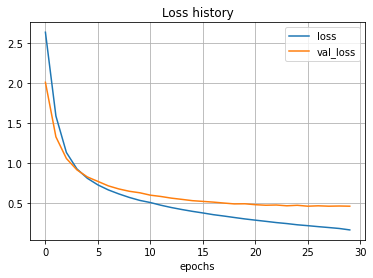

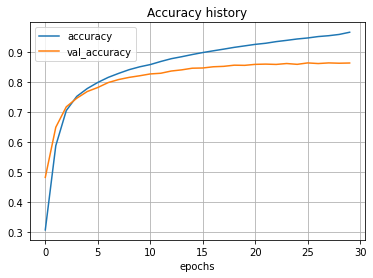

In [16]:
from utils.evaluate import plot_history

plot_history(baseline_model_history)

### Check the predicted labels on a single test sentence

In [17]:
print('Sentence:', texts_test[0])

Sentence: intelogic trace inc. , san antonio , texas , said it bought [num] million shares , or about [num] % , of its common stock from an unaffiliated shareholder for $ [num] a share , or $ [num] million .


In [18]:
print('True POS tags:', labels_test[0])

True POS tags: NNP NNP NNP , NNP NNP , NNP , VBD PRP VBD CD CD NNS , CC IN CD NN , IN PRP$ JJ NN IN DT JJ NN IN $ CD DT NN , CC $ CD CD .


In [19]:
print('Predicted POS tags:', vocabulary_labels[np.argmax(baseline_model(x_test[0:1]), axis=2)][0][:len(labels_test[0].split())])

Predicted POS tags: ['NNP' 'NNP' 'NNP' ',' 'NNP' 'NNP' ',' 'NNP' ',' 'VBD' 'PRP' 'VBD' 'CD'
 'CD' 'NNS' ',' 'CC' 'IN' 'CD' 'NN' ',' 'IN' 'PRP$' 'JJ' 'NN' 'IN' 'DT'
 'JJ' 'NN' 'IN' '$' 'CD' 'DT' 'NN' ',' 'CC' '$' 'CD' 'CD' '.']


### Test score

In [16]:
baseline_model.evaluate(x_test, y_test)

20/20 [==============================] - 1s 23ms/step - loss: 0.4117 - accuracy: 0.8738


[0.411739706993103, 0.8737876415252686]

In [15]:
baseline_model.evaluate(x_test, y_test)

20/20 [==============================] - 1s 29ms/step - loss: 0.4017 - accuracy: 0.8751


[0.40166231989860535, 0.8750808238983154]

### F1 macro (no punctuation)

In [17]:
# Validation

from utils.evaluate import f1_macro

y_pred_val = np.argmax(baseline_model(x_val), axis=2)

f1_macro(y_true=y_val, y_pred=y_pred_val, punctuation_integers=punctuation_integers)

0.6166304552612741

In [16]:
# Validation

from utils.evaluate import f1_macro

y_pred_val = np.argmax(baseline_model(x_val), axis=2)

f1_macro(y_true=y_val, y_pred=y_pred_val, punctuation_integers=punctuation_integers)

0.5795437956764755

In [18]:
# Test

from utils.evaluate import f1_macro

y_pred_test = np.argmax(baseline_model(x_test), axis=2)

f1_macro(y_true=y_test, y_pred=y_pred_test, punctuation_integers=punctuation_integers)

0.6866442015426214

In [17]:
# Test

from utils.evaluate import f1_macro

y_pred_test = np.argmax(baseline_model(x_test), axis=2)

f1_macro(y_true=y_test, y_pred=y_pred_test, punctuation_integers=punctuation_integers)

0.6661823784876819

## First Model

In [23]:
from models.first_model import build_first_model

first_model = build_first_model(n_classes=n_classes, embedding_matrix=embedding_matrix)

In [24]:
first_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 50)          503550    
                                                                 
 bidirectional_1 (Bidirectio  [(None, None, 256),      138240    
 nal)                         (None, 128),                       
                              (None, 128)]                       
                                                                 
 dense_1 (Dense)             (None, None, 47)          12079     
                                                                 
Total params: 653,869
Trainable params: 150,319
Non-trainable params: 503,550
_________________________________________________________________


In [25]:
first_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])

In [26]:
first_model_history = first_model.fit(x=x_train, y=y_train, batch_size=32, epochs=50, validation_data=(x_val, y_val),
                                      callbacks=[early_stopping_callback])

Epoch 1/50
62/62 [==============================] - 13s 114ms/step - loss: 2.3849 - accuracy: 0.3905 - val_loss: 1.5926 - val_accuracy: 0.5898
Epoch 2/50
62/62 [==============================] - 4s 65ms/step - loss: 1.2391 - accuracy: 0.6821 - val_loss: 1.0635 - val_accuracy: 0.7108
Epoch 3/50
62/62 [==============================] - 4s 64ms/step - loss: 0.9070 - accuracy: 0.7568 - val_loss: 0.8742 - val_accuracy: 0.7570
Epoch 4/50
62/62 [==============================] - 4s 65ms/step - loss: 0.7574 - accuracy: 0.7879 - val_loss: 0.7753 - val_accuracy: 0.7772
Epoch 5/50
62/62 [==============================] - 4s 62ms/step - loss: 0.6678 - accuracy: 0.8105 - val_loss: 0.7076 - val_accuracy: 0.7980
Epoch 6/50
62/62 [==============================] - 4s 63ms/step - loss: 0.5999 - accuracy: 0.8298 - val_loss: 0.6639 - val_accuracy: 0.8091
Epoch 7/50
62/62 [==============================] - 4s 63ms/step - loss: 0.5466 - accuracy: 0.8448 - val_loss: 0.6190 - val_accuracy: 0.8230
Epoch 8/50


In [13]:
first_model_history = first_model.fit(x=x_train, y=y_train, batch_size=32, epochs=50, validation_data=(x_val, y_val),
                                      callbacks=[early_stopping_callback])

Epoch 1/50
62/62 [==============================] - 13s 102ms/step - loss: 2.3866 - accuracy: 0.3926 - val_loss: 1.5595 - val_accuracy: 0.5902
Epoch 2/50
62/62 [==============================] - 4s 60ms/step - loss: 1.2029 - accuracy: 0.6886 - val_loss: 1.0303 - val_accuracy: 0.7193
Epoch 3/50
62/62 [==============================] - 4s 62ms/step - loss: 0.8749 - accuracy: 0.7622 - val_loss: 0.8430 - val_accuracy: 0.7644
Epoch 4/50
62/62 [==============================] - 4s 57ms/step - loss: 0.7339 - accuracy: 0.7950 - val_loss: 0.7487 - val_accuracy: 0.7852
Epoch 5/50
62/62 [==============================] - 4s 58ms/step - loss: 0.6526 - accuracy: 0.8152 - val_loss: 0.6873 - val_accuracy: 0.8023
Epoch 6/50
62/62 [==============================] - 4s 59ms/step - loss: 0.5901 - accuracy: 0.8307 - val_loss: 0.6450 - val_accuracy: 0.8127
Epoch 7/50
62/62 [==============================] - 4s 61ms/step - loss: 0.5402 - accuracy: 0.8456 - val_loss: 0.6015 - val_accuracy: 0.8240
Epoch 8/50


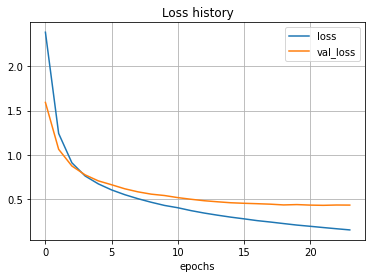

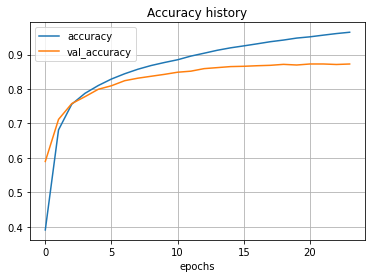

In [29]:
from utils.evaluate import plot_history

plot_history(first_model_history)

### Check the predicted labels on a single test sentence

In [15]:
print('Sentence:', texts_test[0])

Sentence: intelogic trace inc. , san antonio , texas , said it bought 2.7 million shares , or about 18 % , of its common stock from an unaffiliated shareholder for $ 3.625 a share , or $ 9.9 million .


In [16]:
print('True POS tags:', labels_test[0])

True POS tags: NNP NNP NNP , NNP NNP , NNP , VBD PRP VBD CD CD NNS , CC IN CD NN , IN PRP$ JJ NN IN DT JJ NN IN $ CD DT NN , CC $ CD CD .


In [17]:
print('Predicted POS tags:', vocabulary_labels[np.argmax(first_model(x_test[0:1]), axis=2)][0][:len(labels_test[0].split())])

Predicted POS tags: ['NNP' 'NNP' 'NNP' ',' 'NNP' 'NNP' ',' 'NNP' ',' 'VBD' 'PRP' 'VBD' 'CD'
 'CD' 'NNS' ',' 'CC' 'RB' 'CD' 'NN' ',' 'IN' 'PRP$' 'JJ' 'NN' 'IN' 'DT'
 'JJ' 'NN' 'IN' '$' 'CD' 'DT' 'NN' ',' 'CC' '$' 'CD' 'CD' '.']


### Test score

In [27]:
first_model.evaluate(x_test, y_test)

20/20 [==============================] - 0s 13ms/step - loss: 0.3858 - accuracy: 0.8838


[0.385810911655426, 0.8838096261024475]

In [18]:
first_model.evaluate(x_test, y_test)

20/20 [==============================] - 1s 31ms/step - loss: 0.3685 - accuracy: 0.8861


[0.36851179599761963, 0.8861373066902161]

### F1 macro (no punctuation)

In [28]:
# Validation

from utils.evaluate import f1_macro

y_pred_val = np.argmax(first_model(x_val), axis=2)

f1_macro(y_true=y_val, y_pred=y_pred_val, punctuation_integers=punctuation_integers)

0.6174611725895369

In [19]:
# Validation

from utils.evaluate import f1_macro

y_pred_val = np.argmax(first_model(x_val), axis=2)

f1_macro(y_true=y_val, y_pred=y_pred_val, punctuation_integers=punctuation_integers)

0.6207668554703675

In [29]:
# Test

from utils.evaluate import f1_macro

y_pred_test = np.argmax(first_model(x_test), axis=2)

f1_macro(y_true=y_test, y_pred=y_pred_test, punctuation_integers=punctuation_integers)

0.7079978144029354

In [20]:
# Test

from utils.evaluate import f1_macro

y_pred_test = np.argmax(first_model(x_test), axis=2)

f1_macro(y_true=y_test, y_pred=y_pred_test, punctuation_integers=punctuation_integers)

0.6718915642342606

## Second Model

In [19]:
from models.second_model import build_second_model

second_model = build_second_model(n_classes=n_classes, embedding_matrix=embedding_matrix, latent_dim=100)

In [20]:
second_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 50)          503550    
                                                                 
 bidirectional_1 (Bidirectio  [(None, None, 200),      120800    
 nal)                         (None, 100),                       
                              (None, 100),                       
                              (None, 100),                       
                              (None, 100)]                       
                                                                 
 bidirectional_2 (Bidirectio  [(None, None, 200),      240800    
 nal)                         (None, 100),                       
                              (None, 100),                 

In [21]:
import tensorflow as tf

second_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])

In [22]:
second_model_history = second_model.fit(x=x_train, y=y_train, batch_size=32, epochs=50, validation_data=(x_val, y_val),
                                        callbacks=[early_stopping_callback, reduce_lr_callback])

Epoch 1/50
62/62 [==============================] - 37s 240ms/step - loss: 2.7676 - accuracy: 0.2321 - val_loss: 2.2008 - val_accuracy: 0.4114 - lr: 0.0010
Epoch 2/50
62/62 [==============================] - 9s 148ms/step - loss: 1.6507 - accuracy: 0.5524 - val_loss: 1.3022 - val_accuracy: 0.6482 - lr: 0.0010
Epoch 3/50
62/62 [==============================] - 9s 153ms/step - loss: 1.0931 - accuracy: 0.7053 - val_loss: 0.9979 - val_accuracy: 0.7234 - lr: 0.0010
Epoch 4/50
62/62 [==============================] - 10s 159ms/step - loss: 0.8619 - accuracy: 0.7641 - val_loss: 0.8436 - val_accuracy: 0.7639 - lr: 0.0010
Epoch 5/50
62/62 [==============================] - 10s 156ms/step - loss: 0.7334 - accuracy: 0.7963 - val_loss: 0.7478 - val_accuracy: 0.7845 - lr: 0.0010
Epoch 6/50
62/62 [==============================] - 10s 156ms/step - loss: 0.6394 - accuracy: 0.8206 - val_loss: 0.6723 - val_accuracy: 0.8059 - lr: 0.0010
Epoch 7/50
62/62 [==============================] - 10s 156ms/step

In [36]:
second_model_history = second_model.fit(x=x_train, y=y_train, batch_size=32, epochs=50, validation_data=(x_val, y_val),
                                        callbacks=[early_stopping_callback])

Epoch 1/50
62/62 [==============================] - 25s 209ms/step - loss: 2.7787 - accuracy: 0.2261 - val_loss: 2.2651 - val_accuracy: 0.3740
Epoch 2/50
62/62 [==============================] - 9s 137ms/step - loss: 1.6873 - accuracy: 0.5472 - val_loss: 1.3013 - val_accuracy: 0.6403
Epoch 3/50
62/62 [==============================] - 9s 137ms/step - loss: 1.0799 - accuracy: 0.7083 - val_loss: 0.9808 - val_accuracy: 0.7275
Epoch 4/50
62/62 [==============================] - 8s 136ms/step - loss: 0.8476 - accuracy: 0.7661 - val_loss: 0.8261 - val_accuracy: 0.7667
Epoch 5/50
62/62 [==============================] - 8s 137ms/step - loss: 0.7200 - accuracy: 0.7983 - val_loss: 0.7402 - val_accuracy: 0.7889
Epoch 6/50
62/62 [==============================] - 9s 148ms/step - loss: 0.6275 - accuracy: 0.8232 - val_loss: 0.6574 - val_accuracy: 0.8103
Epoch 7/50
62/62 [==============================] - 9s 141ms/step - loss: 0.5556 - accuracy: 0.8436 - val_loss: 0.6044 - val_accuracy: 0.8248
Epoch

In [23]:
second_model_history = second_model.fit(x=x_train, y=y_train, batch_size=32, epochs=50, validation_data=(x_val, y_val),
                                        callbacks=[early_stopping_callback])

Epoch 1/50
62/62 [==============================] - 31s 234ms/step - loss: 2.7612 - accuracy: 0.2338 - val_loss: 2.1904 - val_accuracy: 0.4059
Epoch 2/50
62/62 [==============================] - 9s 149ms/step - loss: 1.6400 - accuracy: 0.5537 - val_loss: 1.2940 - val_accuracy: 0.6464
Epoch 3/50
62/62 [==============================] - 9s 151ms/step - loss: 1.0854 - accuracy: 0.7053 - val_loss: 0.9941 - val_accuracy: 0.7214
Epoch 4/50
62/62 [==============================] - 9s 151ms/step - loss: 0.8570 - accuracy: 0.7626 - val_loss: 0.8406 - val_accuracy: 0.7622
Epoch 5/50
62/62 [==============================] - 9s 152ms/step - loss: 0.7296 - accuracy: 0.7955 - val_loss: 0.7492 - val_accuracy: 0.7825
Epoch 6/50
62/62 [==============================] - 10s 159ms/step - loss: 0.6374 - accuracy: 0.8195 - val_loss: 0.6744 - val_accuracy: 0.8043
Epoch 7/50
62/62 [==============================] - 10s 156ms/step - loss: 0.5660 - accuracy: 0.8401 - val_loss: 0.6189 - val_accuracy: 0.8216
Epo

In [57]:
second_model_history = second_model.fit(x=x_train, y=y_train, batch_size=32, epochs=50, validation_data=(x_val, y_val),
                                        callbacks=[early_stopping_callback])

Epoch 1/50
62/62 [==============================] - 31s 252ms/step - loss: 2.7576 - accuracy: 0.2288 - val_loss: 2.2336 - val_accuracy: 0.3686
Epoch 2/50
62/62 [==============================] - 9s 152ms/step - loss: 1.6728 - accuracy: 0.5488 - val_loss: 1.2961 - val_accuracy: 0.6396
Epoch 3/50
62/62 [==============================] - 9s 149ms/step - loss: 1.0696 - accuracy: 0.7108 - val_loss: 0.9738 - val_accuracy: 0.7315
Epoch 4/50
62/62 [==============================] - 9s 151ms/step - loss: 0.8341 - accuracy: 0.7709 - val_loss: 0.8234 - val_accuracy: 0.7678
Epoch 5/50
62/62 [==============================] - 9s 147ms/step - loss: 0.7084 - accuracy: 0.8025 - val_loss: 0.7343 - val_accuracy: 0.7892
Epoch 6/50
62/62 [==============================] - 9s 147ms/step - loss: 0.6199 - accuracy: 0.8248 - val_loss: 0.6638 - val_accuracy: 0.8089
Epoch 7/50
62/62 [==============================] - 9s 150ms/step - loss: 0.5530 - accuracy: 0.8442 - val_loss: 0.6112 - val_accuracy: 0.8237
Epoch

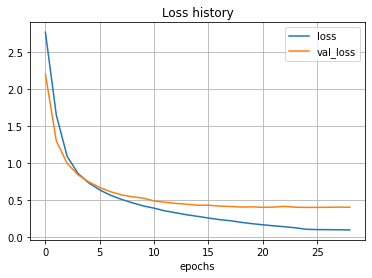

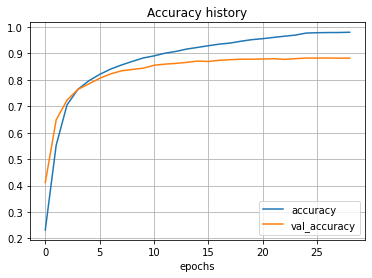

In [24]:
from utils.evaluate import plot_history

plot_history(second_model_history)

### Check the predicted labels on a single test sentence

In [84]:
print('Sentence:', texts_test[0])

Sentence: intelogic trace inc. , san antonio , texas , said it bought 2.7 million shares , or about 18 % , of its common stock from an unaffiliated shareholder for $ 3.625 a share , or $ 9.9 million .


In [85]:
print('True POS tags:', labels_test[0])

True POS tags: NNP NNP NNP , NNP NNP , NNP , VBD PRP VBD CD CD NNS , CC IN CD NN , IN PRP$ JJ NN IN DT JJ NN IN $ CD DT NN , CC $ CD CD .


In [86]:
print('Predicted POS tags:', vocabulary_labels[np.argmax(second_model(x_test[0:1]), axis=2)][0][:len(labels_test[0].split())])

Predicted POS tags: ['NNP' 'NNP' 'NNP' ',' 'NNP' 'NNP' ',' 'NNP' ',' 'VBD' 'PRP' 'VBD' 'CD'
 'CD' 'NNS' ',' 'CC' 'RB' 'CD' 'NN' ',' 'IN' 'PRP$' 'JJ' 'NN' 'IN' 'DT'
 'JJ' 'NN' 'IN' '$' 'CD' 'DT' 'NN' ',' 'CC' '$' 'CD' 'CD' '.']


### Test score

In [23]:
second_model.evaluate(x_test, y_test)

20/20 [==============================] - 1s 34ms/step - loss: 0.3455 - accuracy: 0.8971


[0.3455488979816437, 0.8971291780471802]

In [24]:
second_model.evaluate(x_test, y_test)

20/20 [==============================] - 1s 37ms/step - loss: 0.3570 - accuracy: 0.8916


[0.3569941818714142, 0.8916332721710205]

### F1 macro (no punctuation)

In [25]:
# Validation

from utils.evaluate import f1_macro

y_pred_val = np.argmax(second_model(x_val), axis=2)

f1_macro(y_true=y_val, y_pred=y_pred_val, punctuation_integers=punctuation_integers)

0.6616897922833714

In [25]:
# Validation

from utils.evaluate import f1_macro

y_pred_val = np.argmax(second_model(x_val), axis=2)

f1_macro(y_true=y_val, y_pred=y_pred_val, punctuation_integers=punctuation_integers)

0.6501635838774747

In [26]:
# Test

from utils.evaluate import f1_macro

y_pred_test = np.argmax(second_model(x_test), axis=2)

f1_macro(y_true=y_test, y_pred=y_pred_test, punctuation_integers=punctuation_integers)

0.7893514365606235

In [26]:
# Test

from utils.evaluate import f1_macro

y_pred_test = np.argmax(second_model(x_test), axis=2)

f1_macro(y_true=y_test, y_pred=y_pred_test, punctuation_integers=punctuation_integers)

0.7411085149382056

## Classification report

In [30]:
from sklearn.metrics import classification_report

y_true = y_test.numpy().ravel()

y_pred = np.argmax(second_model(x_test), axis=2).ravel()

padding_mask = y_true==0
y_true = y_true[~padding_mask]
y_pred = y_pred[~padding_mask]

def f(v):
    return v in punctuation_integers
punctuation_mask_test = np.vectorize(f)(y_true)

y_true_noPunctuation = y_true[~punctuation_mask_test]
y_pred_noPunctuation = y_pred[~punctuation_mask_test]

print(classification_report(y_true=y_true_noPunctuation, y_pred=y_pred_noPunctuation, target_names=vocabulary_labels))

              precision    recall  f1-score   support

           2       0.84      0.86      0.85      2366
           3       0.97      0.95      0.96      1626
           4       0.85      0.87      0.86      1495
           5       0.99      0.99      0.99      1330
           6       0.84      0.86      0.85       936
           7       0.72      0.75      0.73       911
           8       0.00      0.00      0.00         0
          10       0.98      0.98      0.98       854
          11       0.89      0.88      0.89       633
          12       0.75      0.78      0.76       380
          13       0.90      0.94      0.92       400
          14       0.99      0.99      0.99       363
          15       1.00      1.00      1.00       385
          16       0.79      0.67      0.73       364
          17       0.91      0.90      0.90       280
          18       0.98      0.98      0.98       192
          19       0.66      0.58      0.62       221
          20       0.82    

c:\Users\pitti\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pitti\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pitti\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

In [33]:
vocabulary_labels[30]

'NNPS'

## Third Model

In [94]:
from models.third_model import build_third_model

third_model = build_third_model(n_classes=n_classes, embedding_matrix=embedding_matrix, latent_dim=100, dense_dim=80)

In [95]:
third_model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_9 (Embedding)     (None, None, 50)          547450    
                                                                 
 bidirectional_14 (Bidirecti  [(None, None, 200),      120800    
 onal)                        (None, 100),                       
                              (None, 100),                       
                              (None, 100),                       
                              (None, 100)]                       
                                                                 
 dense_12 (Dense)            (None, None, 80)          16080     
                                                                 
 dense_13 (Dense)            (None, None, 47)          3807

In [96]:
import tensorflow as tf

third_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])

In [97]:
third_model_history = third_model.fit(x=x_train, y=y_train, batch_size=32, epochs=50, validation_data=(x_val, y_val),
                                      callbacks=[early_stopping_callback])

Epoch 1/50
62/62 [==============================] - 15s 117ms/step - loss: 2.5542 - accuracy: 0.3176 - val_loss: 1.7924 - val_accuracy: 0.5211
Epoch 2/50
62/62 [==============================] - 4s 68ms/step - loss: 1.3454 - accuracy: 0.6405 - val_loss: 1.1013 - val_accuracy: 0.6989
Epoch 3/50
62/62 [==============================] - 4s 68ms/step - loss: 0.9349 - accuracy: 0.7434 - val_loss: 0.8866 - val_accuracy: 0.7472
Epoch 4/50
62/62 [==============================] - 4s 67ms/step - loss: 0.7701 - accuracy: 0.7833 - val_loss: 0.7736 - val_accuracy: 0.7766
Epoch 5/50
62/62 [==============================] - 4s 68ms/step - loss: 0.6750 - accuracy: 0.8078 - val_loss: 0.7104 - val_accuracy: 0.7908
Epoch 6/50
62/62 [==============================] - 4s 70ms/step - loss: 0.6078 - accuracy: 0.8246 - val_loss: 0.6624 - val_accuracy: 0.8067
Epoch 7/50
62/62 [==============================] - 4s 68ms/step - loss: 0.5524 - accuracy: 0.8410 - val_loss: 0.6172 - val_accuracy: 0.8168
Epoch 8/50


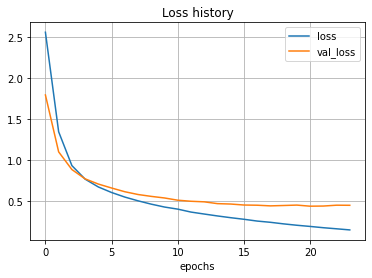

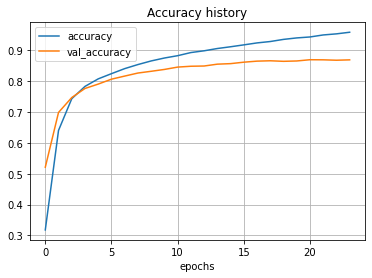

In [99]:
from utils.evaluate import plot_history

plot_history(third_model_history)

### Check the predicted labels on a single test sentence

In [100]:
print('Sentence:', texts_test[0])

Sentence: intelogic trace inc. , san antonio , texas , said it bought 2.7 million shares , or about 18 % , of its common stock from an unaffiliated shareholder for $ 3.625 a share , or $ 9.9 million .


In [101]:
print('True POS tags:', labels_test[0])

True POS tags: NNP NNP NNP , NNP NNP , NNP , VBD PRP VBD CD CD NNS , CC IN CD NN , IN PRP$ JJ NN IN DT JJ NN IN $ CD DT NN , CC $ CD CD .


In [102]:
print('Predicted POS tags:', vocabulary_labels[np.argmax(third_model(x_test[0:1]), axis=2)][0][:len(labels_test[0].split())])

Predicted POS tags: ['NNP' 'NNP' 'NNP' ',' 'NNP' 'NNP' ',' 'NNP' ',' 'VBD' 'PRP' 'VBD' 'CD'
 'CD' 'NNS' ',' 'CC' 'RB' 'CD' 'NN' ',' 'IN' 'PRP$' 'JJ' 'NN' 'IN' 'DT'
 'JJ' 'NN' 'IN' '$' 'CD' 'DT' 'NN' ',' 'CC' '$' 'CD' 'CD' '.']


### Test score

In [103]:
third_model.evaluate(x_test, y_test)

20/20 [==============================] - 0s 19ms/step - loss: 0.3798 - accuracy: 0.8859


[0.3797985017299652, 0.8858786821365356]

### F1 macro (no punctuation)

In [104]:
# Validation

from utils.evaluate import f1_macro

y_pred_val = np.argmax(third_model(x_val), axis=2)

f1_macro(y_true=y_val, y_pred=y_pred_val, punctuation_integers=punctuation_integers)

0.5934009792033329

In [42]:
# Test

from utils.evaluate import f1_macro

y_pred_test = np.argmax(third_model(x_test), axis=2)

f1_macro(y_true=y_test, y_pred=y_pred_test, punctuation_integers=punctuation_integers)

0.6333770221016395